In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np
import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
    accuracy_score,
    precision_score,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
# To use all
# df_long = pd.read_csv("../data/features_30_sec.csv")
# df_short = pd.read_csv("../data/features_3_sec.csv")
# df = pd.concat((df_long, df_short))

# To use just one
# df = pd.read_csv("../data/features_30_sec.csv")
df = pd.read_csv("../data/features_3_sec.csv")

df["genre"] = df["filename"].str.split(".").str[0]

# "blues.00000.0.wav" -> "blues.00000"
# and
# "blues.00000.wav" -> "blues.00000"
# logic: split on period, take first 2 elements, and but back together
df["songname"] = df["filename"].str.split(".").str[:2].str.join(".")

<IPython.core.display.Javascript object>

In [5]:
keep_cols = [
    "chroma_stft_mean",
    "chroma_stft_var",
    "rms_var",
    "zero_crossing_rate_mean",
    "zero_crossing_rate_var",
    "harmony_mean",
    "harmony_var",
    "perceptr_mean",
    "tempo",
    "mfcc1_mean",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc18_mean",
    "mfcc19_mean",
    "mfcc19_var",
]

<IPython.core.display.Javascript object>

In [6]:
# X = df.drop(columns=drop_cols + ["genre"])
X = df[keep_cols]
y = df["genre"]

<IPython.core.display.Javascript object>

In [7]:
X_logged = X.copy()
for c in X_logged:
    if c.endswith("_var"):
        X_logged[c] = np.log(X_logged[c])

<IPython.core.display.Javascript object>

In [8]:
print_vif(X_logged)

VIF results
-------------------------------
const                      1687.442676
chroma_stft_mean              3.821127
chroma_stft_var               2.578163
rms_var                       4.034234
zero_crossing_rate_mean       5.687919
zero_crossing_rate_var        4.774067
harmony_mean                  1.478989
harmony_var                   5.263573
perceptr_mean                 1.575745
tempo                         1.009630
mfcc1_mean                    8.873844
mfcc2_mean                    6.108025
mfcc2_var                     2.658020
mfcc3_mean                    2.402190
mfcc3_var                     2.499945
mfcc4_mean                    2.261148
mfcc4_var                     2.863863
mfcc5_var                     2.733756
mfcc6_mean                    3.361297
mfcc6_var                     2.972196
mfcc7_mean                    2.951355
mfcc8_mean                    3.618786
mfcc8_var                     2.520901
mfcc9_mean                    2.682485
mfcc9_var           

<IPython.core.display.Javascript object>

In [9]:
# og: "blues.00000.0.wav"
# songname: "blues.00000"
# genre: "blues"
song_genre = df[["songname", "genre"]].drop_duplicates()

# train_songs, test_songs = train_test_split(
#     song_genre["songname"], test_size=0.2, random_state=42, stratify=song_genre["genre"]
# )

train_songs = pickle.load(open("../data/train_songs.p", "rb"))
test_songs = pickle.load(open("../data/test_songs.p", "rb"))

train_idxs = df[df["songname"].isin(train_songs)].index
test_idxs = df[df["songname"].isin(test_songs)].index

X_train = X_logged.loc[train_idxs, :]
X_test = X_logged.loc[test_idxs, :]
y_train = y[train_idxs]
y_test = y[test_idxs]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7990, 36) (7990,)
(2000, 36) (2000,)


<IPython.core.display.Javascript object>

In [10]:
# Prove no overlap of songs between train/test
set(train_songs).intersection(set(test_songs))

set()

<IPython.core.display.Javascript object>

In [38]:
num_cols = list(X.columns)

preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        #         ("pca", PCA()),
        # Choose your model and put it here
        (
            "log",
            LogisticRegression(
                max_iter=800, penalty="elasticnet", solver="saga", C=0.1, l1_ratio=0.5
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

0.7058823529411765
0.65


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
groups = list(y_test.unique())

<IPython.core.display.Javascript object>

In [62]:
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=10,
    scoring=make_scorer(precision_score, average="macro"),
    n_jobs=-1,
)
scores

array([0.53536168, 0.53419882, 0.60547243, 0.70456881, 0.55339382,
       0.6074017 , 0.57036941, 0.60904886, 0.59077449, 0.55510651])

<IPython.core.display.Javascript object>

In [63]:
scores.mean()

0.5865696533678604

<IPython.core.display.Javascript object>

In [12]:
coef_df = pd.DataFrame(
    {"feat": X_train.columns, "coef": pipeline.named_steps["log"].coef_[0]}
)
coef_df["abs_coef"] = np.abs(coef_df["coef"])
coef_df.sort_values("abs_coef", ascending=False)

,feat,coef,abs_coef
9,mfcc1_mean,-1.441002,1.441002
10,mfcc2_mean,1.137382,1.137382
2,rms_var,1.039605,1.039605
6,harmony_var,1.028317,1.028317
14,mfcc4_mean,0.913629,0.913629
3,zero_crossing_rate_mean,0.832220,0.832220
17,mfcc6_mean,0.827419,0.827419
11,mfcc2_var,-0.635518,0.635518
12,mfcc3_mean,0.508563,0.508563
19,mfcc7_mean,-0.503556,0.503556


<IPython.core.display.Javascript object>

In [34]:
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[122   0   9   3   0  24  10   0  20  12]
 [  0 194   1   0   0   4   0   0   0   1]
 [ 17   0 111   6   9   7   6   3   5  36]
 [  0   1   6 128  19   1   3  21   2  19]
 [  2   0   8  13  93   0  10  36  33   5]
 [  1  35  12   1   0 136   0   1   3  11]
 [  0   0   0  11   8   0 171   0   3   7]
 [  0   1   7   4  12   4   0 164   3   5]
 [  6   0  17  12  14   0   8   8 126   9]
 [ 17   3  12  37   5  20  34  13   4  55]]
              precision    recall  f1-score   support

       blues       0.74      0.61      0.67       200
   classical       0.83      0.97      0.89       200
     country       0.61      0.56      0.58       200
       disco       0.60      0.64      0.62       200
      hiphop       0.58      0.47      0.52       200
        jazz       0.69      0.68      0.69       200
       metal       0.71      0.85      0.77       200
         pop       0.67      0.82      0.74       200
      reggae       0.63      0.63      0.63       200
        rock       0.34     

<IPython.core.display.Javascript object>

In [14]:
df["predictions"] = pipeline.predict(X_logged[keep_cols])

<IPython.core.display.Javascript object>

In [15]:
long = pd.read_csv("../data/features_30_sec.csv")

<IPython.core.display.Javascript object>

In [16]:
long["vote_pred"] = "none"

for i in range(long["filename"].size):
    curr_file = long["filename"][i]
    file_stripped = curr_file.strip(".wav")
    sub_selection = df["filename"].str.contains(file_stripped)
    prediction = (
        df[sub_selection]["predictions"]
        .value_counts()
        .sort_values(ascending=False)
        .index[0]
    )
    long["vote_pred"][i] = prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<IPython.core.display.Javascript object>

In [17]:
print(confusion_matrix(long["label"], long["vote_pred"]))
print(classification_report(long["label"], long["vote_pred"]))

[[76  1  3  0  3  5  5  0  2  5]
 [ 0 99  1  0  0  0  0  0  0  0]
 [ 6  0 74  4  1  3  1  4  2  5]
 [ 2  1  3 75  6  0  1  4  0  8]
 [ 2  0  1  4 73  0  2 10  6  2]
 [ 2  5  1  0  0 90  0  0  1  1]
 [ 3  0  0  2  1  0 92  0  1  1]
 [ 0  0  4  4  2  0  0 86  2  2]
 [ 5  0  7  3  8  1  1  7 67  1]
 [10  0  5 15  1  4  7  4  3 51]]
              precision    recall  f1-score   support

       blues       0.72      0.76      0.74       100
   classical       0.93      0.99      0.96       100
     country       0.75      0.74      0.74       100
       disco       0.70      0.75      0.72       100
      hiphop       0.77      0.73      0.75       100
        jazz       0.87      0.90      0.89       100
       metal       0.84      0.92      0.88       100
         pop       0.75      0.86      0.80       100
      reggae       0.80      0.67      0.73       100
        rock       0.67      0.51      0.58       100

    accuracy                           0.78      1000
   macro avg       

<IPython.core.display.Javascript object>

In [18]:
long_model_pred = long[keep_cols]
for c in long_model_pred:
    if c.endswith("_var"):
        long_model_pred[c] = np.log(long_model_pred[c])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>

In [19]:
long["model_pred"] = pipeline.predict(long_model_pred)

<IPython.core.display.Javascript object>

In [20]:
long.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,vote_pred,model_pred
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,blues,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,blues,reggae
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,blues,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,blues,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,classical,country


<IPython.core.display.Javascript object>

In [21]:
print(confusion_matrix(long["label"], long["model_pred"]))
print(classification_report(long["label"], long["model_pred"]))

[[71  0  6  2  2  1  4  0 12  2]
 [ 0 86  3  0  0  9  0  0  2  0]
 [ 5  0 69  5  2  0  1  7  8  3]
 [ 2  0  3 70  8  1  0  8  4  4]
 [ 2  0  0  3 69  0  2  9 14  1]
 [ 7  2  9  1  0 75  0  2  3  1]
 [ 3  0  0  4  7  0 82  0  1  3]
 [ 0  0  2  3  2  0  0 91  1  1]
 [ 5  0  2  1  7  0  1  6 78  0]
 [13  0 10 16  4  1  5  7  8 36]]
              precision    recall  f1-score   support

       blues       0.66      0.71      0.68       100
   classical       0.98      0.86      0.91       100
     country       0.66      0.69      0.68       100
       disco       0.67      0.70      0.68       100
      hiphop       0.68      0.69      0.69       100
        jazz       0.86      0.75      0.80       100
       metal       0.86      0.82      0.84       100
         pop       0.70      0.91      0.79       100
      reggae       0.60      0.78      0.68       100
        rock       0.71      0.36      0.48       100

    accuracy                           0.73      1000
   macro avg       

<IPython.core.display.Javascript object>

In [22]:
long.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,vote_pred,model_pred
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,blues,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,blues,reggae
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,blues,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,blues,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,classical,country


<IPython.core.display.Javascript object>

In [23]:
long["songname"] = long["filename"].str.split(".").str[:2].str.join(".")

<IPython.core.display.Javascript object>

In [24]:
train_idxs = long[long["songname"].isin(train_songs)].index
test_idxs = long[long["songname"].isin(test_songs)].index

train_idxs

Int64Index([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
            ...
            985, 986, 989, 990, 992, 993, 995, 996, 997, 998],
           dtype='int64', length=800)

<IPython.core.display.Javascript object>

In [25]:
long_train = long.loc[train_idxs, :]
long_test = long.loc[test_idxs, :]

<IPython.core.display.Javascript object>

In [26]:
print(confusion_matrix(long_test["label"], long_test["vote_pred"]))
print(classification_report(long_test["label"], long_test["vote_pred"]))

[[13  0  0  0  0  3  1  0  2  1]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 1  0 14  0  1  1  1  0  0  2]
 [ 0  0  1 14  2  0  0  1  0  2]
 [ 0  0  0  1 12  0  1  4  2  0]
 [ 0  3  1  0  0 16  0  0  0  0]
 [ 0  0  0  1  1  0 18  0  0  0]
 [ 0  0  1  0  0  0  0 18  0  1]
 [ 0  0  2  1  1  0  1  1 13  1]
 [ 2  0  1  6  0  2  2  1  1  5]]
              precision    recall  f1-score   support

       blues       0.81      0.65      0.72        20
   classical       0.87      1.00      0.93        20
     country       0.70      0.70      0.70        20
       disco       0.61      0.70      0.65        20
      hiphop       0.71      0.60      0.65        20
        jazz       0.73      0.80      0.76        20
       metal       0.75      0.90      0.82        20
         pop       0.72      0.90      0.80        20
      reggae       0.72      0.65      0.68        20
        rock       0.42      0.25      0.31        20

    accuracy                           0.71       200
   macro avg       

<IPython.core.display.Javascript object>

In [27]:
print(confusion_matrix(long_train["label"], long_train["vote_pred"]))
print(classification_report(long_train["label"], long_train["vote_pred"]))

[[63  1  3  0  3  2  4  0  0  4]
 [ 0 79  1  0  0  0  0  0  0  0]
 [ 5  0 60  4  0  2  0  4  2  3]
 [ 2  1  2 61  4  0  1  3  0  6]
 [ 2  0  1  3 61  0  1  6  4  2]
 [ 2  2  0  0  0 74  0  0  1  1]
 [ 3  0  0  1  0  0 74  0  1  1]
 [ 0  0  3  4  2  0  0 68  2  1]
 [ 5  0  5  2  7  1  0  6 54  0]
 [ 8  0  4  9  1  2  5  3  2 46]]
              precision    recall  f1-score   support

       blues       0.70      0.79      0.74        80
   classical       0.95      0.99      0.97        80
     country       0.76      0.75      0.75        80
       disco       0.73      0.76      0.74        80
      hiphop       0.78      0.76      0.77        80
        jazz       0.91      0.93      0.92        80
       metal       0.87      0.93      0.90        80
         pop       0.76      0.85      0.80        80
      reggae       0.82      0.68      0.74        80
        rock       0.72      0.57      0.64        80

    accuracy                           0.80       800
   macro avg       

<IPython.core.display.Javascript object>

In [35]:
no_rock = long_test[long_test["label"] != "rock"]
print(confusion_matrix(no_rock["label"], no_rock["vote_pred"]))
print(classification_report(no_rock["label"], no_rock["vote_pred"]))

[[13  0  0  0  0  3  1  0  2  1]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 1  0 14  0  1  1  1  0  0  2]
 [ 0  0  1 14  2  0  0  1  0  2]
 [ 0  0  0  1 12  0  1  4  2  0]
 [ 0  3  1  0  0 16  0  0  0  0]
 [ 0  0  0  1  1  0 18  0  0  0]
 [ 0  0  1  0  0  0  0 18  0  1]
 [ 0  0  2  1  1  0  1  1 13  1]
 [ 0  0  0  0  0  0  0  0  0  0]]
              precision    recall  f1-score   support

       blues       0.93      0.65      0.76        20
   classical       0.87      1.00      0.93        20
     country       0.74      0.70      0.72        20
       disco       0.82      0.70      0.76        20
      hiphop       0.71      0.60      0.65        20
        jazz       0.80      0.80      0.80        20
       metal       0.82      0.90      0.86        20
         pop       0.75      0.90      0.82        20
      reggae       0.76      0.65      0.70        20
        rock       0.00      0.00      0.00         0

    accuracy                           0.77       180
   macro avg       

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

In [29]:
plot_df = pd.concat([X_logged, y], 1)
plot_df

,chroma_stft_mean,chroma_stft_var,rms_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,tempo,mfcc1_mean,...,mfcc13_mean,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc19_var,genre
0,0.335406,-2.396365,-5.649009,0.081851,-7.491712,-0.000078,-4.785064,-0.000068,129.199219,-118.627914,...,-4.681614,-7.233477,3.755859,-2.853603,3.681027,-3.241280,0.722209,-5.050335,3.515064,blues
1,0.343065,-2.451706,-6.536409,0.087173,-6.878565,-0.000099,-5.308294,-0.000103,123.046875,-125.590706,...,-7.717751,-8.300493,4.228071,4.074709,4.170507,-6.055294,0.159015,-2.837699,4.575029,blues
2,0.346815,-2.383330,-5.377274,0.071383,-7.762753,-0.000066,-4.383954,0.000065,123.046875,-132.441940,...,-4.677677,-2.424750,3.918273,4.806280,4.209703,-1.768610,2.378768,-1.938424,3.971251,blues
3,0.363639,-2.443502,-6.012662,0.069426,-8.098503,-0.000014,-4.789304,0.000018,123.046875,-118.231087,...,-4.362739,-9.889441,3.799220,-1.359111,3.865758,-3.841155,1.218588,-3.580352,3.928609,blues
4,0.335579,-2.428959,-6.376606,0.070095,-8.149578,0.000041,-4.642445,-0.000106,123.046875,-105.968376,...,-5.681399,-7.986080,3.684292,2.092937,3.412347,0.664582,1.689446,-3.392489,3.286115,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,-2.519309,-9.236958,0.072885,-7.321693,-0.000034,-6.159446,-0.000020,123.046875,-224.972168,...,-16.715929,-2.225949,4.386414,5.773784,3.749174,-9.094270,-4.246976,-5.625813,3.887814,rock
9986,0.372564,-2.493433,-9.341785,0.089111,-6.920756,-0.000027,-5.844111,-0.000045,83.354335,-192.806641,...,-19.505360,-8.003813,3.533665,2.074155,3.478628,-12.375726,-3.081278,-11.960546,4.150288,rock
9987,0.347481,-2.418901,-7.262631,0.072194,-5.576867,0.000015,-6.009739,-0.000029,123.046875,-287.840088,...,-13.186050,-9.124884,3.787080,-1.005473,4.359630,-2.524483,4.809936,1.775686,3.883261,rock
9988,0.387527,-2.467278,-8.045673,0.104072,-6.239466,0.000004,-5.604525,-0.000048,123.046875,-162.659592,...,-14.699870,-5.266814,3.026968,4.123402,3.343700,-5.363541,6.462601,2.354765,3.212601,rock


<IPython.core.display.Javascript object>

In [30]:
top_five = list(coef_df.sort_values("abs_coef", ascending=False)["feat"])[:5]
top_five

['mfcc1_mean', 'mfcc2_mean', 'rms_var', 'harmony_var', 'mfcc4_mean']

<IPython.core.display.Javascript object>

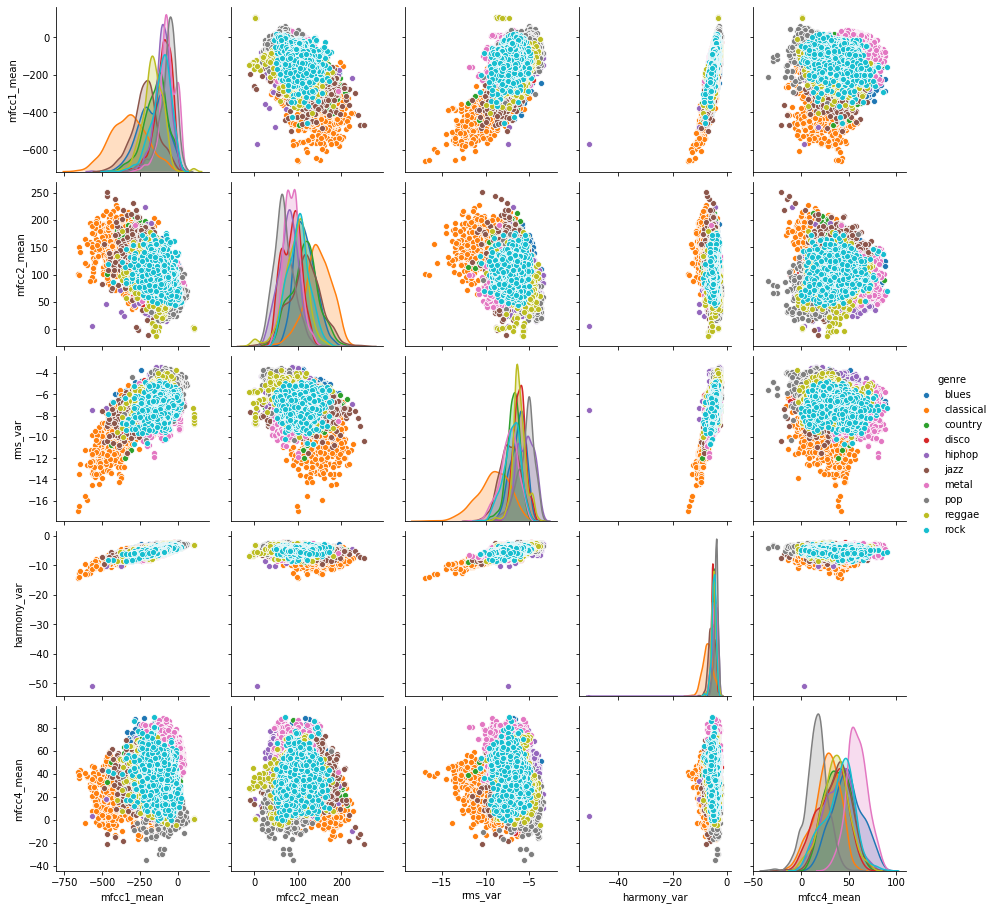

<IPython.core.display.Javascript object>

In [31]:
sns.pairplot(data=plot_df[top_five + ["genre"]], hue="genre")